In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.tools.plotting import parallel_coordinates

import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

from scipy import stats
import math

In [8]:
xls = pd.ExcelFile('2014年基本信息表.xls')
data_upperHalf = xls.parse('基本信息表2014上半年')
data_lowerHalf = xls.parse('基本信息表2014下半年')
data = pd.DataFrame()
data = pd.concat([data_upperHalf,data_lowerHalf],ignore_index=True)

xls = pd.ExcelFile('2015年基本信息表.xls')
data_upperHalf = xls.parse('基本信息表2015年上半年')
data_lowerHalf = xls.parse('基本信息表2015年上半年')
data = pd.concat([data,data_upperHalf,data_lowerHalf],ignore_index=True)

xls = pd.ExcelFile('2016年基本信息表.xls')
data_upperHalf = xls.parse('2016年上半年基本信息表')
data_lowerHalf = xls.parse('2016年下半年基本信息表')
data = pd.concat([data,data_upperHalf,data_lowerHalf],ignore_index=True)
xls.close()

del data_upperHalf
del data_lowerHalf
#添加 路宽，是否双道  属性
#删除事故特征，留下道路特征，环境特征；清洗事故类型特征
data.drop(['事故编号','受伤人数','当事人总数','抢救死亡人数Q','机动车数量','死亡人数',
           '直接财产损失','米数','轻伤人数','重伤人数','非机动车数量','行人数量','路名','事故形态',\
           '单车事故','是否简易程序','路外事故类型','车辆间事故.1','逃逸事故侦破','事故认定原因',\
           '事故认定原因分类小类'],axis=1,inplace=True)
data.drop(['事故初查原因','事故初查原因分类','失踪人数','文书状态',\
           '是否逃逸','调解人1','调解人2','车辆间事故','运载危险品事故后果'],axis=1,inplace=True)
data.drop(['公安部事故编号','所属中队'],axis=1,inplace=True)
data = data[data.事故类型.isin(['简易程序事故','伤人事故','死亡事故','财产损失事故'])]

data_attach_notnull = data[data['路面附着系数'].notnull()]


data_way = data_attach_notnull[['单向路宽','双向路宽']]
data_way.columns=['oneWay','twoWay']
#填充空值为-1
data_way.fillna(-1,inplace=True)
def isTwowayRoad(row,oneWay,twoWay):
    if row[oneWay] == -1 and row[twoWay] == -1:
        return np.nan
    elif row[oneWay] == -1:
        return '是'
    elif  row[twoWay] == -1:
        return  '否'
def getRoadWidth(row,oneWay,twoWay):
    if row[oneWay] == -1 and row[twoWay] == -1:
        return np.nan
    elif row[oneWay] == -1:
        return row[twoWay]
    elif  row[twoWay] == -1:
        return  row[oneWay]
data_isTwoWay = pd.DataFrame(data_way.apply(isTwowayRoad, axis=1, oneWay='oneWay', twoWay='twoWay'),\
                             columns=['isTwoWay'])
data_roadWidth = pd.DataFrame(data_way.apply(getRoadWidth, axis=1, oneWay='oneWay', twoWay='twoWay'),\
                             columns=['roadWidth'])
data_attach_notnull.insert(value=data_isTwoWay,column='是否双道',loc=3)
data_attach_notnull.insert(value=data_roadWidth,column='路宽',loc=4)
# pd.DataFrame(data_attach_notnull[(data_attach_notnull['路宽']==-1)])[['是否双道','路宽','单向路宽','双向路宽']]
data_attach_notnull.drop(['单向路宽','双向路宽'],axis=1,inplace=True)
del data_way,data_isTwoWay,data_roadWidth

data_attach_notnull.dropna(subset=['是否双道'],inplace=True,axis=0)

# 设置编号
data_attach_notnull['index']=range(len(data_attach_notnull))
data_attach_notnull.set_index(data_attach_notnull['index'],inplace=True)
data_attach_notnull.drop(['index'],axis=1,inplace=True)
data_attach_notnull['中央隔离设施'].fillna('绿化带',inplace=True)
data_attach_notnull['道路安全属性'].fillna('正常路段',inplace=True)
data_attach_notnull['道路安全隐患督办等级'].fillna(4.0,inplace=True)

#将事故发生时间化解为是否节假日，是否白天
isHolidayFrom140101To161231 = pd.read_excel('isHolidayFrom140101To161231_17.10.23_re.xlsx')
date = pd.DataFrame(data_attach_notnull['事故发生时间'])
date = pd.to_datetime(date['事故发生时间'])
def getAccidentDayWithoutHour(i):
    day = str(i.day)
    month = str(i.month)
    if i.day<10:
        day = '0'+day
    if i.month<10:
        month = '0'+month
    theDate = str(i.year)+month+day
    return theDate
accidentDayWithoutHour = pd.DataFrame(date.apply(getAccidentDayWithoutHour))
isHolidays = list()
for i in accidentDayWithoutHour['事故发生时间']:
    isH = isHolidayFrom140101To161231[isHolidayFrom140101To161231.date_day==int(i)]['isHoliday'].iloc[0]
    isHolidays.append(isH)    
isHolidays = pd.DataFrame(isHolidays)
isHolidays['index'] = range(len(isHolidays))
isHolidays = isHolidays.set_index(['index'])
data_attach_notnull.insert(loc=1,column='是否节假日',value=isHolidays)
del isHolidayFrom140101To161231,accidentDayWithoutHour,isHolidays,isH
#添加是否白天属性
#白天或夜晚
isDayorNight = list()
for i in date:
    if i.hour>=19 or i.hour<7:
        isDayorNight.append('夜晚')
    else:
        isDayorNight.append('白天')
isDayorNight = pd.Series(isDayorNight)
data_attach_notnull.insert(2,'是否白天',isDayorNight)
del isDayorNight,date
data_attach_notnull.drop(['事故发生时间'],axis=1,inplace=True)

data_attach_notnull['公路行政等级'].fillna('其他',inplace=True)

#交通信号方式（控制）
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==345,'交通信号方式（控制）']='方式1'
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==45,'交通信号方式（控制）']='方式2'
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==456,'交通信号方式（控制）']='方式3'
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==3456,'交通信号方式（控制）']='方式4'



D:\ProgramFiles\Anaconda3\lib\site-packages\pandas\core\frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: SettingWithCopyWarning: 
A value is trying to 

In [29]:
nan_columns = {}
length_data = len(data_attach_notnull)
for i in range(len(data_attach_notnull.columns)): 
    odds = sum(data_attach_notnull[data_attach_notnull.columns[i]].isnull())/length_data
    nan_columns[data_attach_notnull.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+': '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()

中央隔离设施: 0.0  是否节假日: 0.0  是否白天: 0.0  事故地点: 0.0  
是否双道: 0.0  路宽: 0.0  事故多发点段: 0.0  事故类型: 0.0  
交通信号方式（控制）: 0.0  交通标志标线完善: 0.0  公路行政等级: 0.0  公里数: 0.0  
其他交通安全设施不全: 0.0  在道路横断面位置: 0.0  地形: 0.0  天气: 0.0  
所辖乡镇: 0.0  损坏机动车数: 0.0  损坏非机动车数: 0.0  星期: 0.0  
是否运载危险物品: 0.0  涉外事故: 0.0  照明条件: 0.0  现场: 0.0  
能见度: 0.0  行政区划: 0.0  路侧防护设施类型: 0.0  路口路段类型: 0.0  
路号: 0.0  路表情况: 0.0  路面状况: 0.0  路面结构: 0.0  
路面附着系数: 0.0  道路安全属性: 0.0  道路安全隐患督办等级: 0.0  道路物理隔离: 0.0  
道路类型: 0.0  道路线型: 0.0  长下坡路段: 0.0  

In [14]:
data_attach_notnull.to_excel('data_analyzeWithRF_17.11.20.xlsx')

# 生成训练集

In [2]:
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
data_attach_notnull = pd.read_excel('data_analyzeWithRF_17.11.20.xlsx')

In [30]:
data_attach_notnull.drop(['所辖乡镇','星期','涉外事故','现场','行政区划','现场','公里数'],axis=1,inplace=True)
data_attach_notnull.drop(['路号','事故地点'],axis=1,inplace=True)
data_attach_notnull.drop(['损坏机动车数','损坏非机动车数'],axis=1,inplace=True)
#生成训练集和测试集
data_attach_notnull['index'] = range(len(data_attach_notnull))
data_attach_notnull_test = data_attach_notnull.sample(frac=0.2,replace=False)
#获取训练集
index = ~data_attach_notnull.index.isin(data_attach_notnull_test['index'])
data_attach_notnull_train = data_attach_notnull[index]


#转换为数字
data_attach_notnull.drop(['index'],axis=1,inplace=True)
data_attach_notnull_train.drop(['index'],axis=1,inplace=True)
data_attach_notnull_test.drop(['index'],axis=1,inplace=True)
columnsToNum = list(data_attach_notnull_train.columns)

set_toNum = pd.DataFrame()
for i in columnsToNum:
    set_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull[i])


trainSet_toNum = pd.DataFrame()
for i in columnsToNum:
    trainSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_train[i])

# columnsToNum = list(data_attach_notnull_test.columns)
testSet_toNum = pd.DataFrame()
for i in columnsToNum:
    testSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_test[i])

del data_attach_notnull_train,data_attach_notnull_test#,data_attach_notnull

#统一训练集、测试集格式
train_features = trainSet_toNum.drop(['事故类型'],axis=1).columns

x_all =np.array(set_toNum.drop(['事故类型'],axis=1)) 
y_all = np.array(set_toNum['事故类型'])
y = np.zeros((len(y_all),len(set_toNum.groupby('事故类型')) ))
for i in range(len(y_all)):
    y[i][y_all[i]] = 1
y_all = np.mat(y)
x_all = np.mat(x_all)
# y_all = np.mat(y_all)

x_train =np.array(trainSet_toNum.drop(['事故类型'],axis=1)) 
y_train = np.array(trainSet_toNum['事故类型'])
y = np.zeros((len(y_train),len(trainSet_toNum.groupby('事故类型')) ))
for i in range(len(y_train)):
    y[i][y_train[i]] = 1
y_train = np.mat(y)
x_train = np.mat(x_train)
# y_train = np.mat(y_train)


x_test =np.array(testSet_toNum.drop(['事故类型'],axis=1)) 
y_test = np.array(testSet_toNum['事故类型'])
y = np.zeros((len(y_test),len(testSet_toNum.groupby('事故类型')) ))
for i in range(len(y_test)):
    y[i][y_test[i]] = 1
y_test = np.mat(y)
x_test = np.mat(x_test)
# y_test = np.mat(y_test)


del y,trainSet_toNum,testSet_toNum

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel

# 训练模型

In [31]:
forest = RandomForestClassifier(max_features='sqrt',random_state=10,oob_score=True)
forest.fit(x_all,y_all)
print(forest.oob_score_)

0.828205128205


D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [32]:
#turn n_estimator
param_test1 = {'n_estimators':list(range(20,200,10))}

forest = GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt',random_state=10),\
                     param_grid=param_test1,scoring='roc_auc',cv=5)
forest.fit(x_all,y_all)
forest.grid_scores_,forest.best_params_,forest.best_score_#cv_results_

# forest = RandomForestClassifier(n_estimators=115,)
# forest.fit(x_train,y_train)
# print (forest.oob_score_)
# y_pred= forest.predict(x_test)
# print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_pred) )

([mean: 0.87952, std: 0.13959, params: {'n_estimators': 20},
  mean: 0.87394, std: 0.14655, params: {'n_estimators': 30},
  mean: 0.88740, std: 0.14039, params: {'n_estimators': 40},
  mean: 0.88274, std: 0.14193, params: {'n_estimators': 50},
  mean: 0.88750, std: 0.13497, params: {'n_estimators': 60},
  mean: 0.89263, std: 0.12679, params: {'n_estimators': 70},
  mean: 0.89326, std: 0.12495, params: {'n_estimators': 80},
  mean: 0.89753, std: 0.11478, params: {'n_estimators': 90},
  mean: 0.89757, std: 0.11662, params: {'n_estimators': 100},
  mean: 0.89695, std: 0.11976, params: {'n_estimators': 110},
  mean: 0.89663, std: 0.12223, params: {'n_estimators': 120},
  mean: 0.89836, std: 0.12133, params: {'n_estimators': 130},
  mean: 0.89617, std: 0.12221, params: {'n_estimators': 140},
  mean: 0.89598, std: 0.12207, params: {'n_estimators': 150},
  mean: 0.89533, std: 0.12348, params: {'n_estimators': 160},
  mean: 0.89571, std: 0.12516, params: {'n_estimators': 170},
  mean: 0.89573,

In [33]:
#n_estimators=7，
#'max_depth':list(range(2,18,1))
param_test2 = {'min_samples_split':list(range(2,30,2))}#, 
forest = GridSearchCV(estimator=RandomForestClassifier(n_estimators=130,\
                                                    max_features='sqrt',oob_score=True,\
                                                    random_state=10),\
                     param_grid = param_test2,scoring='roc_auc',cv=5,iid=False)
forest.fit(x_all,y_all)
forest.grid_scores_,forest.best_params_,forest.best_score_
#max_depth,min_samples_split使用默认值

([mean: 0.89836, std: 0.12133, params: {'min_samples_split': 2},
  mean: 0.89420, std: 0.11152, params: {'min_samples_split': 4},
  mean: 0.86590, std: 0.10419, params: {'min_samples_split': 6},
  mean: 0.85136, std: 0.10960, params: {'min_samples_split': 8},
  mean: 0.82927, std: 0.10966, params: {'min_samples_split': 10},
  mean: 0.82111, std: 0.09388, params: {'min_samples_split': 12},
  mean: 0.80718, std: 0.09280, params: {'min_samples_split': 14},
  mean: 0.79085, std: 0.08498, params: {'min_samples_split': 16},
  mean: 0.78268, std: 0.09086, params: {'min_samples_split': 18},
  mean: 0.77485, std: 0.09402, params: {'min_samples_split': 20},
  mean: 0.77100, std: 0.09480, params: {'min_samples_split': 22},
  mean: 0.76593, std: 0.09160, params: {'min_samples_split': 24},
  mean: 0.75299, std: 0.08967, params: {'min_samples_split': 26},
  mean: 0.74985, std: 0.09339, params: {'min_samples_split': 28}],
 {'min_samples_split': 2},
 0.8983617294871165)

In [34]:
#测试oob_score_
rf1 = RandomForestClassifier(n_estimators= 130,max_features='sqrt' ,min_samples_split=2,oob_score=True, random_state=10)
rf1.fit(x_all,y_all)
print (rf1.oob_score_)

0.882051282051


In [35]:
param_test3 = {'min_samples_split':list(range(2,10,1)),\
               'min_samples_leaf':list(range(1,10,1))}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 130,
                                  max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(x_all,y_all)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.89836, std: 0.12133, params: {'min_samples_leaf': 1, 'min_samples_split': 2},
  mean: 0.89439, std: 0.12656, params: {'min_samples_leaf': 1, 'min_samples_split': 3},
  mean: 0.89420, std: 0.11152, params: {'min_samples_leaf': 1, 'min_samples_split': 4},
  mean: 0.87120, std: 0.12677, params: {'min_samples_leaf': 1, 'min_samples_split': 5},
  mean: 0.86590, std: 0.10419, params: {'min_samples_leaf': 1, 'min_samples_split': 6},
  mean: 0.85691, std: 0.11120, params: {'min_samples_leaf': 1, 'min_samples_split': 7},
  mean: 0.85136, std: 0.10960, params: {'min_samples_leaf': 1, 'min_samples_split': 8},
  mean: 0.83457, std: 0.10898, params: {'min_samples_leaf': 1, 'min_samples_split': 9},
  mean: 0.86458, std: 0.11985, params: {'min_samples_leaf': 2, 'min_samples_split': 2},
  mean: 0.86458, std: 0.11985, params: {'min_samples_leaf': 2, 'min_samples_split': 3},
  mean: 0.86458, std: 0.11985, params: {'min_samples_leaf': 2, 'min_samples_split': 4},
  mean: 0.86184, std: 0.10481, p

In [36]:
param_test4 = {'max_features':list(range(1,15,1))}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 130,\
                                    max_features='sqrt' ,min_samples_leaf=1, min_samples_split=2,oob_score=True, random_state=10),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(x_all,y_all)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.88654, std: 0.13448, params: {'max_features': 1},
  mean: 0.89187, std: 0.12799, params: {'max_features': 2},
  mean: 0.89902, std: 0.12147, params: {'max_features': 3},
  mean: 0.89431, std: 0.13198, params: {'max_features': 4},
  mean: 0.89836, std: 0.12133, params: {'max_features': 5},
  mean: 0.89897, std: 0.12256, params: {'max_features': 6},
  mean: 0.89812, std: 0.11912, params: {'max_features': 7},
  mean: 0.89244, std: 0.12984, params: {'max_features': 8},
  mean: 0.87946, std: 0.13309, params: {'max_features': 9},
  mean: 0.89851, std: 0.11174, params: {'max_features': 10},
  mean: 0.89308, std: 0.12422, params: {'max_features': 11},
  mean: 0.89966, std: 0.11119, params: {'max_features': 12},
  mean: 0.90643, std: 0.10776, params: {'max_features': 13},
  mean: 0.89981, std: 0.12540, params: {'max_features': 14}],
 {'max_features': 13},
 0.9064288048552754)

In [37]:
#测试oob_score_
rf1 = RandomForestClassifier(n_estimators= 130,\
                             max_features=13,min_samples_leaf=1, min_samples_split=2,max_depth=10,\
                             oob_score=True, random_state=10)
rf1.fit(x_all,y_all)
print (rf1.oob_score_)

0.882051282051


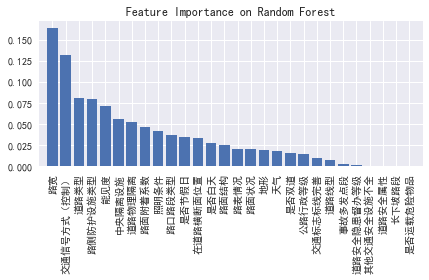

In [44]:
importances = rf1.feature_importances_
indice = np.argsort(importances)[::-1]#按照索引对应值的大小对索引排序
# for i in range(x_train.shape[1]):
#     print('%2d) %-*s %f'%(i+1, 30, train_features[indice[i]], importances[indice[i]]))

# feat_imp = pd.Series(importances[indice])
# feat_imp.plot(kind='bar', title='Feature Importances on Random Forest')
# plt.ylabel('Feature Importance Score')
    
plt.title('Feature Importance on Random Forest')
plt.bar(range(x_train.shape[1]),
       importances[indice],
#        color='lightblue',
       align='center')
plt.xticks(range(x_train.shape[1]),
          train_features[indice],
           rotation=90)
plt.xlim([-1,x_train.shape[1]])
plt.tight_layout()
plt.show()

# 相关性分析

In [67]:
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False

In [57]:
# sns.countplot(data_attach_notnull['事故类型'])
data_attach_notnull.loc[data_attach_notnull['事故类型']=='财产损失事故','事故类型'] = 1
data_attach_notnull.loc[data_attach_notnull['事故类型']=='伤人事故','事故类型'] = 2
data_attach_notnull.loc[data_attach_notnull['事故类型']=='死亡事故','事故类型'] = 3

D:\ProgramFiles\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
#交通信号方式（控制）

#根据以下代码转化为数字
# data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==345,'交通信号方式（控制）']='方式1'
# data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==45,'交通信号方式（控制）']='方式2'
# data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==456,'交通信号方式（控制）']='方式3'
# data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==3456,'交通信号方式（控制）']='方式4'

# data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==345,'交通信号方式（控制）']=9
# data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==45,'交通信号方式（控制）']=8
# data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==456,'交通信号方式（控制）']=7
# data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==3456,'交通信号方式（控制）']=6

data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']=='方式1','交通信号方式（控制）']=9
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']=='方式2','交通信号方式（控制）']=8
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']=='方式3','交通信号方式（控制）']=7
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']=='方式4','交通信号方式（控制）']=6
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']=='无信号','交通信号方式（控制）']=10
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']=='其它安全设施','交通信号方式（控制）']=1

D:\ProgramFiles\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [58]:
dataForAnalyze = data_attach_notnull[['路宽','交通信号方式（控制）','能见度','路侧防护设施类型','道路物理隔离','路口路段类型','事故类型']]

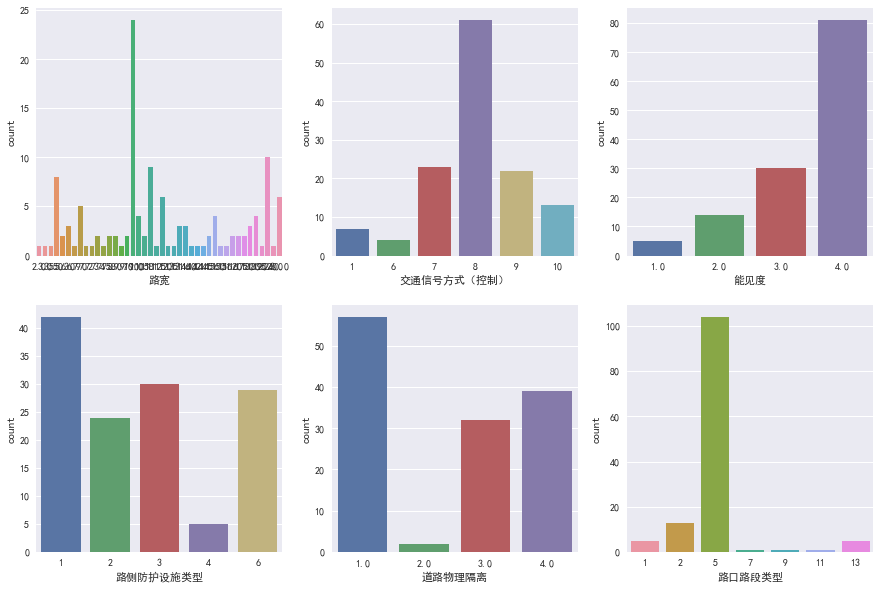

In [62]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
x=0
y=0
for i in [x for x in dataForAnalyze.columns if x not in ['事故类型']]:
    sns.countplot(dataForAnalyze[i],ax=axes[x,y])
    y+=1
    if y==3:
        y=0
        x+=1

In [61]:
#转化为数字
dataForAnalyze.loc[dataForAnalyze['路侧防护设施类型']=='绿化带','路侧防护设施类型'] = int(1)
dataForAnalyze.loc[dataForAnalyze['路侧防护设施类型']=='混凝土护拦','路侧防护设施类型'] = int(2.0)
dataForAnalyze.loc[dataForAnalyze['路侧防护设施类型']=='防护墩(柱)','路侧防护设施类型'] = int(3.0)
dataForAnalyze.loc[dataForAnalyze['路侧防护设施类型']=='行道树','路侧防护设施类型'] = int(4.0)
dataForAnalyze.loc[dataForAnalyze['路侧防护设施类型']=='金属护拦','路侧防护设施类型'] = int(5.0)
dataForAnalyze.loc[dataForAnalyze['路侧防护设施类型']=='无防护','路侧防护设施类型'] = int(6.0)


dataForAnalyze.loc[dataForAnalyze['道路物理隔离']=='中心隔离','道路物理隔离'] = 1.0
dataForAnalyze.loc[dataForAnalyze['道路物理隔离']=='机非隔离','道路物理隔离'] = 2.0
dataForAnalyze.loc[dataForAnalyze['道路物理隔离']=='中心隔离加机非隔离','道路物理隔离'] = 3.0
dataForAnalyze.loc[dataForAnalyze['道路物理隔离']=='无隔离','道路物理隔离'] = 4.0


dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='三枝分叉口','路口路段类型'] = 1
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='四枝分叉口','路口路段类型'] = 2
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='多枝分叉口','路口路段类型'] = 3
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='环行交叉','路口路段类型'] = 4
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='普通路段','路口路段类型'] = 5
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='变窄路段','路口路段类型'] = 6
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='路侧险要路段','路口路段类型'] = 7
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='匝道口','路口路段类型'] = 8
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='路段进出处','路口路段类型'] = 9
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='高架路段','路口路段类型'] = 10
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='桥梁','路口路段类型'] = 11
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='隧道','路口路段类型'] = 12
dataForAnalyze.loc[dataForAnalyze['路口路段类型']=='其他特殊路段','路口路段类型'] = 13


D:\ProgramFiles\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
dataForAnalyze.to_excel('dataForAnalyzeRF_17.11.21.xlsx')

### 在此读取分析数据

In [2]:
dataForAnalyze = pd.read_excel('dataForAnalyzeRF_17.11.21.xlsx')

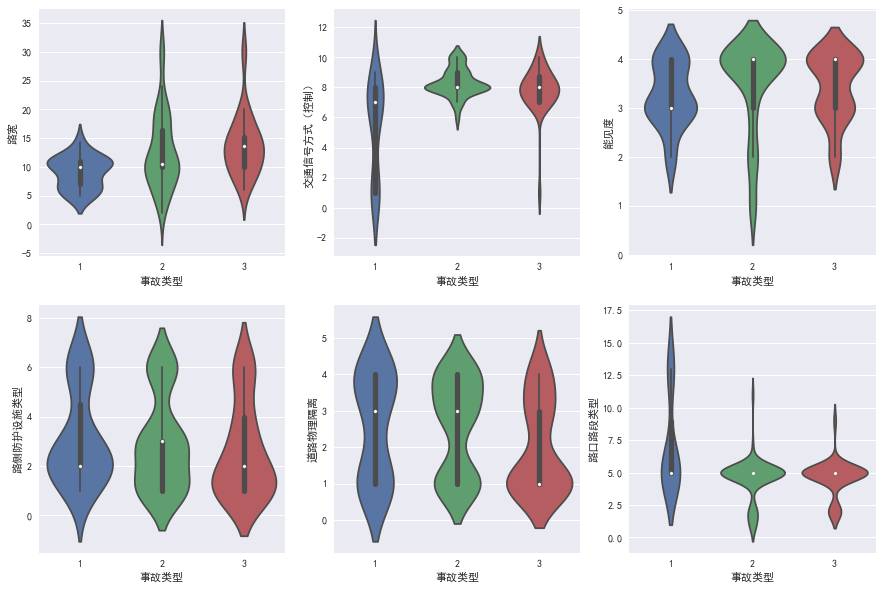

In [69]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
x=0
y=0
for i in [z for z in dataForAnalyze.columns if z not in ['事故类型','index']]:
    sns.violinplot(x='事故类型',y=i,data=dataForAnalyze,ax=axes[x,y])
    y+=1
    if y==3:
        y=0
        x+=1

D:\ProgramFiles\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
D:\ProgramFiles\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
D:\ProgramFiles\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
D:\ProgramFiles\Anaconda3\lib\site-packages\numpy\ma\core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


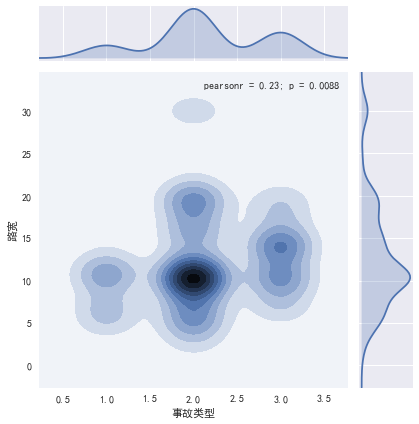

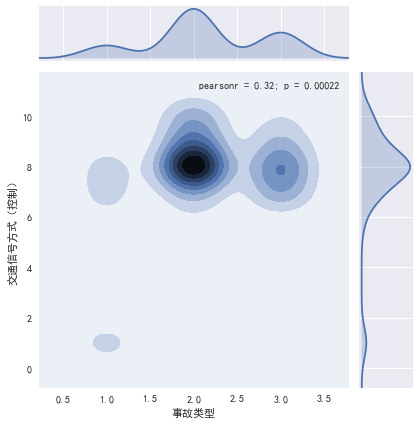

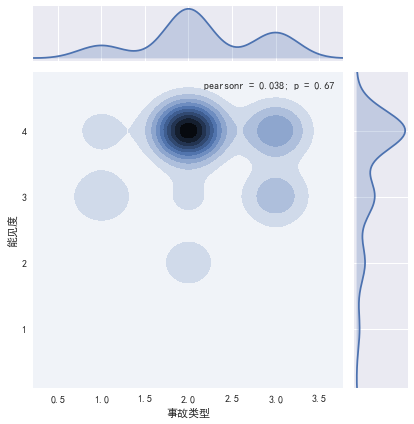

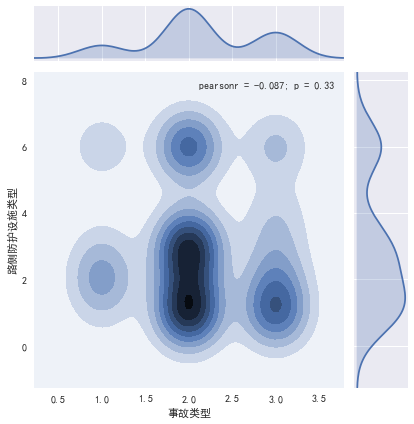

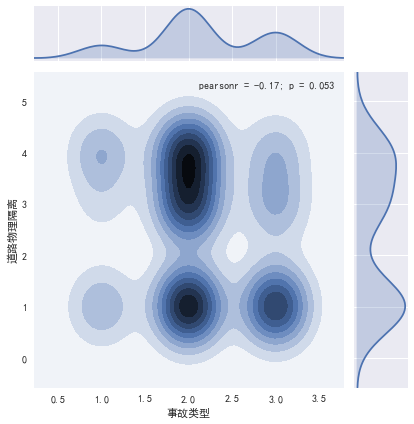

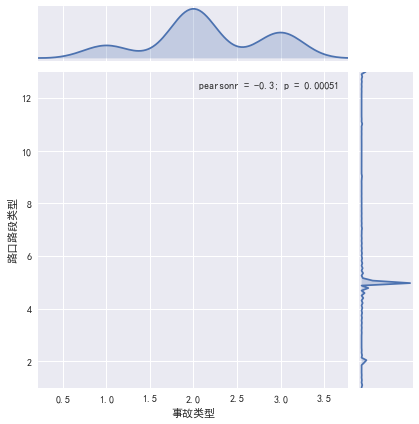

In [73]:
for i in [z for z in dataForAnalyze.columns if z not in ['事故类型','index']]:
    sns.jointplot(x='事故类型',y=i,data=dataForAnalyze,kind='kde')

In [4]:
dataForAnalyze[['交通信号方式（控制）','能见度','路侧防护设施类型', '道路物理隔离', '路口路段类型','事故类型' ]]\
        .to_excel('dataForAnalyzeConcat1_17.11.22.xlsx')

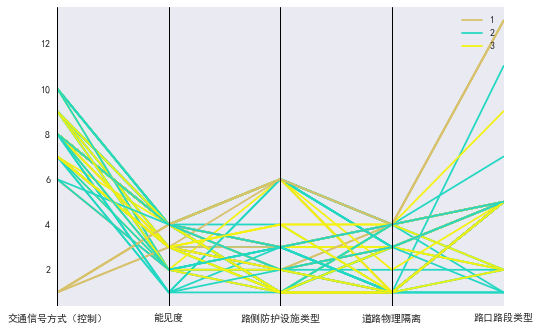

In [3]:
parallel_coordinates(dataForAnalyze[['交通信号方式（控制）','能见度','路侧防护设施类型',\
                                     '道路物理隔离', '路口路段类型','事故类型' ]], '事故类型')